In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Data visualization

We conduct a pseudo-out-of-sample forecast experiement with historical data to study the comparison between the VAR model and NN models.   

We consider 7 macroeconomic quarterly series, which includes consumption, investment, output, labor, inflation, wage, and interest rate. The quarterly data spans over 1947 Q3 - 2004 Q4. They come from the famous Smets and Wouters (2007). In consistency with the original paper, we take the log deviations of per capita real output, consumption, investment, and real wages; we take the log of per capita hours worked and inflation, and we take the levels of the bank rate and corporate bond spread. 

While it is interesting to use the data in levels as targets, we decide to use the transformed data as target variables, because this is macroeconomic convention.

In [8]:
data = pd.read_csv('usdata.csv', header = None)

In [9]:
start_date = "30/09/1947"
end_date = "31/12/2004"
data.index = pd.date_range(start_date, end_date, freq='Q')
data.columns = ['dc', 'dinve', 'dy', 'labobs', 'pinfobs', 'dw', 'robs']

In [10]:
data

,dc,dinve,dy,labobs,pinfobs,dw,robs
1947-09-30,0.125190,3.745902,-0.346647,2.405991,1.733213,-0.390911,0.209167
1947-12-31,-0.311351,7.863267,1.151612,3.120085,2.482240,0.149491,0.251667
1948-03-31,0.429219,3.036307,1.160385,3.722781,0.760128,1.804115,0.272500
1948-06-30,1.102048,1.053555,1.533762,3.705329,0.883676,0.374202,0.275000
1948-09-30,-0.514536,-0.054367,0.247688,3.716847,1.840954,0.628307,0.287500
...,...,...,...,...,...,...,...
2003-12-31,0.477771,2.487176,0.681041,-2.091594,0.352658,0.637123,0.251667
2004-03-31,1.062724,0.843084,1.017161,-1.887397,0.676434,-0.152529,0.250833
2004-06-30,0.134491,3.271152,0.579111,-2.287390,0.786671,0.640072,0.252500
2004-09-30,0.890421,2.167986,0.664565,-1.879071,0.359229,0.983931,0.358333


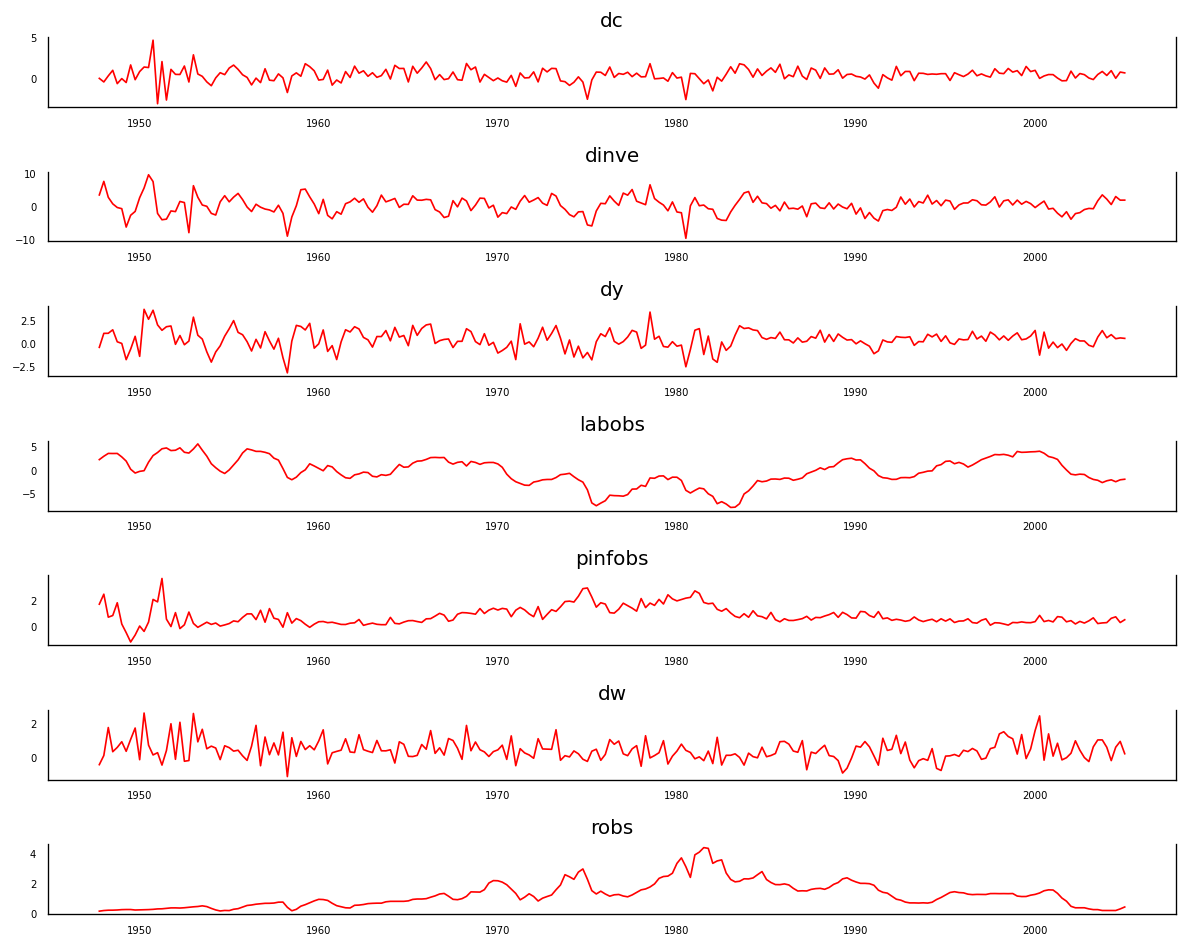

In [11]:
# Plot
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data_temp = data[data.columns[i]]
    ax.plot(data_temp, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

The variables consumption, investment, output and wage look more volatile, and we can observe some comovement among them. 

# Vector-autoregression model

The key to predict multivariate macroeconomic time series is to depict both the temporal variation for each feature and the possible correlations between them in each period. A VAR model serves such purposes by using matrices as the coefficients to depict the linear dependencies between periods and between features. It assumes a stochastic process that generates the data and attempts to estimate parameters of a model that can be viewed as a smooth approximation to the structure that generated the data.

Traditional methods like VAR have proven to be quite effective in many circumstances. 

Consider a k-th order VAR model as the following,
\begin{equation}
\begin{split}
\label{eq:VARmodel}
x_t = A_1y_{t-1} + ... + A_kx_{t-k} + \epsilon_t, \quad \textrm{where} \quad  & A \in R^{d\times d}, \quad \epsilon \in R^d, \\
& t = \max(k+1),...,T
\end{split}
\end{equation}

where $x$ represents vectors of $d$ features and k-th order means the number of time lags we consider. To estimate the model, we can present the above in a compact form:

\begin{equation}
\begin{split}
\label{eq:VARmodel_matrix}
Y = XB + E, \quad \textrm{where} \quad &Y \in R^{N\times p}, \quad X \in R^{N\times kp} \\
&B \in R^{kp\times p}, \quad E \in R^{N\times p} \quad \textrm{for} \quad N = T - k + 1 
\end{split}
\end{equation}

Least squares can be applied to estimate the above model. We use the tsa.vector\_ar api offered by statsmodels for testing and estimating our VAR model.

## Train-test split

In [12]:
# train-test split without shuffling
nobs = 8
train, test = data[0:-nobs], data[-nobs:]
X_train, Y_train = train[0:-nobs], train[-nobs:]

## Stationarity check

In NN models, series does not need to be stationary, but stationarity might improve performance. In VAR models, it is required that time series be stationary.

In [13]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [14]:
print('Augmented Dickey-Fuller Test: Consumption Time Series')
augmented_dickey_fuller_statistics(X_train['dc'])
print('Augmented Dickey-Fuller Test: Investment Time Series')
augmented_dickey_fuller_statistics(X_train['dinve'])
print('Augmented Dickey-Fuller Test: Output Time Series')
augmented_dickey_fuller_statistics(X_train['dy'])
print('Augmented Dickey-Fuller Test: Labor Time Series')
augmented_dickey_fuller_statistics(X_train['labobs'])
print('Augmented Dickey-Fuller Test: Inflation Time Series')
augmented_dickey_fuller_statistics(X_train['pinfobs'])
print('Augmented Dickey-Fuller Test: Wage Time Series')
augmented_dickey_fuller_statistics(X_train['dw'])
print('Augmented Dickey-Fuller Test: Federal Funds Rate Time Series')
augmented_dickey_fuller_statistics(X_train['robs'])

Augmented Dickey-Fuller Test: Consumption Time Series
ADF Statistic: -7.959492
p-value: 0.000000
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Investment Time Series
ADF Statistic: -5.537069
p-value: 0.000002
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Output Time Series
ADF Statistic: -10.310731
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Labor Time Series
ADF Statistic: -3.024506
p-value: 0.032668
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Inflation Time Series
ADF Statistic: -3.149142
p-value: 0.023124
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Wage Time Series
ADF Statistic: -4.000188
p-value: 0.001410
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Federal Funds Rate Time Series
ADF Statistic: -2.130093
p-value: 0.232587
Critical V

Dickey-Fuller test may be used to identify whether a time-series is stationary or not.

As the result shows, we have all the series stationary except for the variable "robs", which refers to the federal funds rate. However, I will leave it as it is, in consistency with the original paper.

## Order selection

In [15]:
model = VAR(X_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.564053753587929
BIC :  -6.680333747579818
FPE :  0.000518896408401419
HQIC:  -7.206913084889726 

Lag Order = 2
AIC :  -7.669763399630522
BIC :  -6.007303216420327
FPE :  0.0004675027082695002
HQIC:  -6.997835826719727 

Lag Order = 3
AIC :  -7.715446877857663
BIC :  -5.269067007927264
FPE :  0.0004482665843704257
HQIC:  -6.726571545605622 

Lag Order = 4
AIC :  -7.640882727145163
BIC :  -4.4053454474516105
FPE :  0.000486414014112377
HQIC:  -6.3328749124129295 

Lag Order = 5
AIC :  -7.528457884960886
BIC :  -3.498466346706663
FPE :  0.0005507801522184765
HQIC:  -5.8991086391165855 

Lag Order = 6
AIC :  -7.521880171227661
BIC :  -2.6920774693521965
FPE :  0.0005645064864440195
HQIC:  -5.568955956008732 

Lag Order = 7
AIC :  -7.449869570859264
BIC :  -1.8148377948067083
FPE :  0.0006225415865785282
HQIC:  -5.1711118874345745 

Lag Order = 8
AIC :  -7.342372450316382
BIC :  -0.8966317156219983
FPE :  0.0007182414425673967
HQIC:  -4.735497461399818 

Lag Order =

By AIC, we choose lag 3.

## Train the model

In [16]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Sep, 2021
Time:                     23:36:30
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -5.26907
Nobs:                     211.000    HQIC:                  -6.72657
Log likelihood:          -1127.79    FPE:                0.000448267
AIC:                     -7.71545    Det(Omega_mle):     0.000223884
--------------------------------------------------------------------
Results for equation dc
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.037685         0.193330            5.367           0.000
L1.dc             -0.428698         0.094254           -4.548           0.000
L1.dinve           0.008954         0.032827            0.273           0.7

## Check for serial correlation of residuals

In [17]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

dc : 1.96
dinve : 1.97
dy : 1.98
labobs : 1.98
pinfobs : 1.96
dw : 1.97
robs : 1.94


We check serial correlation by Durbin-Watson statistic which always have a value ranging between 0 and 4. Because the values of our test are close to 2, there is no problem of serial correlation.

This is indication that a linear model like VAR is already almost sufficient to describe the data generation process, and NN might not outperform it in this aspect.

## Forecast

In [18]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

3


array([[ 0.711647  , -1.61049329,  0.34085369, -0.68008592,  0.44463593,
         0.46350862,  0.4375    ],
       [ 0.57708493, -0.67542912,  0.33625692, -0.75188355,  0.31899486,
         0.02810719,  0.435     ],
       [ 0.16804908, -0.33038731, -0.12530637, -1.3975298 ,  0.48709396,
        -0.21027717,  0.36083333]])

In [19]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
var_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns)
var_forecast.columns = [str(col) + '_var_forecast' for col in var_forecast.columns]
var_forecast

,dc_var_forecast,dinve_var_forecast,dy_var_forecast,labobs_var_forecast,pinfobs_var_forecast,dw_var_forecast,robs_var_forecast
2003-03-31,0.702664,1.418921,1.005135,-1.210742,0.233141,0.552001,0.308415
2003-06-30,1.063478,2.959456,1.282328,-0.532957,0.154605,0.400671,0.350483
2003-09-30,1.158388,2.917860,1.354023,0.085287,0.242951,0.512469,0.416397
2003-12-31,0.964703,2.904340,1.294538,0.721526,0.307332,0.523093,0.461781
2004-03-31,0.990605,2.484532,1.184499,1.287397,0.378156,0.543664,0.523849
2004-06-30,0.852993,2.030081,1.091153,1.753563,0.425294,0.542265,0.593579
2004-09-30,0.776912,1.591791,0.931383,2.076919,0.468792,0.585165,0.650993
2004-12-31,0.686868,1.220091,0.807525,2.282976,0.491248,0.589051,0.699106


## Evaluation

In [20]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mse = np.mean((forecast - actual)**2)  # MSE
    return({ 'mse':mse})

print('Forecast Accuracy of: dc')
accuracy_prod = forecast_accuracy(var_forecast['dc_var_forecast'].values, test['dc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dinve')
accuracy_prod = forecast_accuracy(var_forecast['dinve_var_forecast'].values, test['dinve'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dy')
accuracy_prod = forecast_accuracy(var_forecast['dy_var_forecast'].values, test['dy'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: labobs')
accuracy_prod = forecast_accuracy(var_forecast['labobs_var_forecast'].values, test['labobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pinfobs')
accuracy_prod = forecast_accuracy(var_forecast['pinfobs_var_forecast'].values, test['pinfobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dw')
accuracy_prod = forecast_accuracy(var_forecast['dw_var_forecast'].values, test['dw'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: robs')
accuracy_prod = forecast_accuracy(var_forecast['robs_var_forecast'].values, test['robs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: dc
mse :  0.1954

Forecast Accuracy of: dinve
mse :  1.3465

Forecast Accuracy of: dy
mse :  0.3412

Forecast Accuracy of: labobs
mse :  9.4155

Forecast Accuracy of: pinfobs
mse :  0.0615

Forecast Accuracy of: dw
mse :  0.1942

Forecast Accuracy of: robs
mse :  0.0492


# Machine learning models

## Train-validation-test split

We only have one time series in total, to be transformed first into train, validation and test sets and then into a supervised learning problem. I shall not randomly split the data into train and validation sets, for efficient use of the data and to prevent leakage. For the train and validation sets, I will split them into overlapping windows of equal lenghs, with the time difference of 1 quarter. Those windows are of the length n_steps + nobs, where n_steps refers to the number of lags and nobs refers to the forecast values. 

In [21]:
n_steps = 10
n_valid = 16
n = data.shape[0]
d = data.shape[1]
n_train = n - nobs - n_valid

In [22]:
test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

## Splitting into subsequences

We choose to return sequence as output at each step, instead of vector. To be more exact, at timestep 0 the model predicts periods 1-8, and at timestep 1 the model predicts periods 2-9, until the last timestep. The input is a 3D array of (sample size, time steps, features). The target, as windows for each timestep in the input, should be a 4D array, with one more dimension "nobs". However, the sequential api only takes in 3D arrays. In fact, only the first two arguments need to be identified as they have to match the weight matrices. So I just have to merge the last 2 dimensions in the target into 1 dimension, keeping in mind of the items in different positions. For instance, for the input, in the vertical direction lies the features for each sample. I create the target so that features for different forward-looking periods are stacked together. 

In [23]:
# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

In [24]:
X_train.shape, Y_train.shape

((188, 10, 7), (188, 10, 56))

In [25]:
# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

In [26]:
X_valid.shape, Y_valid.shape

((8, 10, 7), (8, 10, 56))

In [27]:
# Split test set into subsequences
X_test = np.array(data[-nobs-n_steps:-nobs])
Y_test = np.empty((n_steps, d * nobs))
for j in range(nobs):
    Y_test[:, j*d : (j+1)*d] = test[j+1 : j+n_steps+1]

In [28]:
X_test.shape, Y_test.shape

((10, 7), (10, 56))

In [29]:
X_test = X_test.reshape(1, n_steps, d)
Y_test = Y_test.reshape(1, n_steps, d * nobs)

In [30]:
X_test.shape, Y_test.shape

((1, 10, 7), (1, 10, 56))

## Normalization

First, it needs to be carefully considered whether normalization fits under this scenario. For instance, if information like the comparative magnitude of the time steps or features matters for prediction, then it would be a bad idea to normalize the data. It can be ensured that this is no issue with the features, but whether there would be information loss when it comes to time steps is still unclear. I assume that it is enough to know the comparative magnitude of the same time steps among instances, and leave this for further validation.

MinMaxScaler from sklearn can only normalize against 2D arrays. Here I am normalizing along the 3rd axis--in other words, across the 1st and 2nd axis. Therefore I normalize the data like below:

In [31]:
X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

In [32]:
Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

In [33]:
X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

## Hyperparameter tuning for the RNN model

Machine learning models, despite their advantages, suffer from a high degree of sensitivity to their hyperparameters. We have prepared a validation set to test for the best hyperparameters. 

Due to computational constraint on our computers, we choose the number of neurons in the hidden layers, the number of hidden layers, and the learning rate in one loop, and the number of time steps in another loop after the previous step is done. We define a "build model" function with various parameters as its parameters which will compile a NN model, pass it to a wrapper "Keras regressor" which will work like a regular sklearn regressor, and call its "fit", "predict" and "score" methods in the loops. 

In every loop, we use the train set to train the model and then evaluate it on the validation set we have carefully prepared. Then we select the grid which gives the lowest total MSE. Ideally we should also select the number of iterations in this grid--We cannot use early stopping here because we do not have an extra validation set for it. Doing it in yet another loop would not create the best result in grid sense. Instead we set the number of iterations to 100 in the validation process, and then we use early stopping using the validation set in the final model. 

We are interested in tuning the following hyperparemeters:

1. Number of time steps
2. Number of hidden layers
3. Number of neurons per hidden layer
4. Learning rate

In [165]:
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3, input_shape=[None, 7]):
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(n_neurons, return_sequences = True, input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.SimpleRNN(n_neurons, return_sequences = True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [166]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Due to computational constraint of my computer, I will have to separate the selection of model-related hyperparameters and time steps and epochs, and select them in sequence.

### Select number of hidden layers, number of neurons per hidden layer and learning rate

In [167]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(2, 10, 2).tolist(),
    "learning_rate":[0.001, 0.003, 0.05]
}

In [168]:
from sklearn.model_selection import ParameterGrid

best_score = -np.inf
for g in ParameterGrid(param_distribs):
    keras_reg.set_params(**g)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_grid = g

Epoch 1/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2381
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2254
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2193
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2132
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2072
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2009
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1881
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1814
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1746
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1675
Epoch 13/100
6/6 [==============================] - 0s 3ms/st

In [169]:
best_grid

{'learning_rate': 0.003, 'n_hidden': 3, 'n_neurons': 4}

### Select number of time steps

In [170]:
best_score = -np.inf
best_timesteps = 5

timesteps_grid = np.arange(1, 20, 2)

for n_steps in timesteps_grid:
    
    # Train-validation-test split
    test = data[-nobs-n_steps:]
    valid = data[-n_steps-n_valid-nobs:-nobs]
    train = data[:n_train]
    
    # Split train set into subsequences
    X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
    Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
    for i in range(n_train - n_steps - nobs):
        X_train[i, :, :] = train[i : i+n_steps]
        for j in range(nobs):
            Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]
    
    # Split validation set into subsequences
    X_valid = np.empty((n_valid - nobs, n_steps, d))
    Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
    for i in range(n_valid - nobs):
        X_valid[i, :, :] = valid[i : i+n_steps]
        for j in range(nobs):
            Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]
    
    # Normalization
    X_min = X_train.min(axis=(0, 1), keepdims=True)
    X_max = X_train.max(axis=(0, 1), keepdims=True)
    X_train_norm = (X_train - X_min)/(X_max - X_min)
    
    Y_min = Y_train.min(axis=(0, 1), keepdims=True)
    Y_max = Y_train.max(axis=(0, 1), keepdims=True)
    Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)
    
    X_valid_norm = (X_valid - X_min)/(X_max - X_min)
    Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)
    
    # fit
    keras_reg.set_params(**best_grid)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_timesteps = n_steps

Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2229
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1854
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1477
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1116
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0807
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0577
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0432
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 11/100
7/7 [==============================] - 0s 997us/step - loss: 0.0280
Epoch 12/100
7/7 [==============================] - 0s 997us/step - loss: 0.0278
Epoch 13/100
7/7 [==============================] - 0s 99

In [171]:
best_timesteps

9

## RNN fit and predict

While VAR models assume an underlying stochastic process and linearity in the data, it can be difficult in reality to tease out this structure, and time series data can be nonlinear. Recursive neural networks are potentially able to address those problems. RNN depicts temporal relationships by unrolling the network through time, which has a loop where the output is sent back to itself. 

Given a time series $x_1, x_2, \dots, x_t$, the RNN is defiend by the following recurrent relation

\begin{equation}
h_t = \phi(Wx_t + Uh_{t-1} + b)
\end{equation}

where $x_t \in R^d$ is the input at time $t$, $W\in R ^{n\times d}, U\in R ^{n\times n}, b\in R ^n$ are the hidden state parameters, $h_t$ and $h_{t-1} \in R ^n$ are the hidden state vectors at times $t$ and $t-1$, respectively, and $\phi$ is the activation function.

In [34]:
n_steps = 9

test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [35]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(4, return_sequences = True, input_shape = [None, 7]),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [36]:
optimizer = keras.optimizers.Adam(learning_rate=0.003)

In [37]:
model.compile(loss='mse', optimizer=optimizer)

In [38]:
history = model.fit(X_train_norm, Y_train_norm, epochs = 100, validation_data = (X_valid_norm, Y_valid_norm),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
6/6 [==============================] - 0s 77ms/step - loss: 0.2655 - val_loss: 0.0525
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2044 - val_loss: 0.0535
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1585 - val_loss: 0.0635
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1244 - val_loss: 0.0889
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0973 - val_loss: 0.1218
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0766 - val_loss: 0.1430
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0610 - val_loss: 0.1537
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0496 - val_loss: 0.1647
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0416 - val_loss: 0.1779
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0362 - val_loss: 0.1885
Epoch 11/100
6/6 [==========

In [39]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max - Y_min) + Y_min

We are only interested in the output from the last time step. And the output is made up of 8 periods of 7 features. To compute the MSE, I do the following reshape.

In [40]:
Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs, d)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs, d)
np.mean((Y_pred_last_step - Y_test_last_step)**2, axis = 0)

array([0.27400581, 5.00790936, 0.39786991, 1.7453293 , 0.14376815,
       0.37750757, 1.1516426 ])

In [42]:
rnn_columns = [str(col) + '_rnn_forecast' for col in data.columns]

In [43]:
rnn_forecast = pd.DataFrame(Y_pred_last_step, index = var_forecast.index, columns = rnn_columns)

In [44]:
rnn_forecast

,dc_rnn_forecast,dinve_rnn_forecast,dy_rnn_forecast,labobs_rnn_forecast,pinfobs_rnn_forecast,dw_rnn_forecast,robs_rnn_forecast
2003-03-31,0.394697,0.891159,0.686225,-0.163129,1.136181,0.456210,1.105080
2003-06-30,0.661159,-1.795617,0.647910,-0.138481,0.624002,-0.191964,1.403303
2003-09-30,-0.156829,0.645104,0.647553,-1.926026,0.262016,0.319685,1.487825
2003-12-31,0.605852,0.511750,0.498717,-0.395240,0.715233,0.447209,1.471653
2004-03-31,0.400604,-0.272965,0.008678,-0.508652,1.142683,0.528697,1.014613
2004-06-30,-0.266128,0.917245,0.008002,-2.124305,1.027873,0.495455,1.489335
2004-09-30,0.540963,0.725001,0.719459,-0.235557,0.918494,0.556543,1.470443
2004-12-31,0.635063,0.952543,0.165967,-2.037489,0.927516,0.588322,1.503916


## Hyperparameter tuning for the LSTM model

We are interested in tuning the following hyperparemeters:

1. Number of time steps
2. Number of hidden layers
3. Number of neurons per hidden layer
4. Learning rate

In [30]:
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3, input_shape=[None, 7]):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_neurons, return_sequences = True, input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.LSTM(n_neurons, return_sequences = True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [31]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Due to computational constraint of my computer, I will have to separate the selection of model-related hyperparameters and time steps and epochs, and select them in sequence.

### Select number of hidden layers, number of neurons per hidden layer and learning rate

In [230]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(2, 30, 2).tolist(),
    "learning_rate":[0.003, 0.005, 0.01]
}

In [231]:
from sklearn.model_selection import ParameterGrid

for g in ParameterGrid(param_distribs):
    keras_reg.set_params(**g)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_grid = g

Epoch 1/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2361
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2140
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1951
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1781
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1619
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1460
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1157
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0877
Epoch 11/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0631
Epoch 13/100
6/6 [==============================] - 0s 2ms/st

ResourceExhaustedError:  OOM when allocating tensor with shape[32,11,56] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_4396513]

Function call stack:
train_function


In [232]:
best_grid

{'learning_rate': 0.003, 'n_hidden': 3, 'n_neurons': 24}

### Select number of time steps

In [33]:
best_score = -np.inf
best_timesteps = 5

timesteps_grid = np.arange(1, 20, 2)

for n_steps in timesteps_grid:
    
    # Train-validation-test split
    test = data[-nobs-n_steps:]
    valid = data[-n_steps-n_valid-nobs:-nobs]
    train = data[:n_train]
    
    # Split train set into subsequences
    X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
    Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
    for i in range(n_train - n_steps - nobs):
        X_train[i, :, :] = train[i : i+n_steps]
        for j in range(nobs):
            Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]
    
    # Split validation set into subsequences
    X_valid = np.empty((n_valid - nobs, n_steps, d))
    Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
    for i in range(n_valid - nobs):
        X_valid[i, :, :] = valid[i : i+n_steps]
        for j in range(nobs):
            Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]
    
    # Normlization
    X_min = X_train.min(axis=(0, 1), keepdims=True)
    X_max = X_train.max(axis=(0, 1), keepdims=True)
    X_train_norm = (X_train - X_min)/(X_max - X_min)
    
    Y_min = Y_train.min(axis=(0, 1), keepdims=True)
    Y_max = Y_train.max(axis=(0, 1), keepdims=True)
    Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)
    
    X_valid_norm = (X_valid - X_min)/(X_max - X_min)
    Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)
    
    # Fit
    keras_reg.set_params(**best_grid)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_timesteps = n_steps

Epoch 1/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2297
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2041
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1685
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1109
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0464
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0402
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0285
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0279
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 13/100
7/7 [==============================] - 0s 5ms/st

In [34]:
best_timesteps

13

## LSTM fit and predict

Although RNN's are simple to understand and often effective in practice, they have limited capacity to learn long-term dependencies. LSTM has a more advanced memory mechanism than RNN. By adding more memories and inputs in "cell", we may avoid the gradient vanishing problem in RNN model. A forget gate can also be set in cell, which can be applied to determine whether memory will be erased or kept to the next cell state.

In addition to the recurrent component $h_t$, the model also includes a long term memory component $c_t$ which is manipulated at each time step through various "gates".

\begin{equation}
f_t = \phi (W_fx_t+U_fh_{t-1} + b_f)
\end{equation}
\begin{equation}
i_t = \phi(W_ix_t + U_ih_{t-1} + b_i)
\end{equation}
\begin{equation}
\tilde{c} = \tanh (W_c x_t + U_c h_{t-1} + b_c)
\end{equation}
\begin{equation}
c_t = i_t \otimes \tilde{c}_t + f_t \otimes c_{t-1}
\end{equation}
\begin{equation}
o_t = \phi (W_ox_t + U_oh_{t-1} + b_o)
\end{equation}
\begin{equation}
h_t = o_t \otimes \tanh (c_t)
\end{equation}

In [45]:
n_steps = 13

test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [46]:
model = keras.models.Sequential([
    keras.layers.LSTM(24, return_sequences = True, input_shape = [None, 7]),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [47]:
optimizer = keras.optimizers.Adam(learning_rate=0.003)

In [48]:
model.compile(loss='mse', optimizer=optimizer)

In [49]:
history = model.fit(X_train_norm, Y_train_norm, epochs = 100, validation_data = (X_valid_norm, Y_valid_norm), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
6/6 [==============================] - 1s 224ms/step - loss: 0.2200 - val_loss: 0.0111
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 0.1542 - val_loss: 0.1473
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0978 - val_loss: 0.1332
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.1688
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0472 - val_loss: 0.1890
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0409 - val_loss: 0.1882
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0369 - val_loss: 0.1911
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0340 - val_loss: 0.1987
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0321 - val_loss: 0.1979
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0309 - val_loss: 0.1995
Epoch 11/100
6/6 [

In [50]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max - Y_min) + Y_min

We are only interested in the output from the last time step. And the output is made up of 8 periods of 7 features. To compute the MSE, I do the following reshape.

In [51]:
Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs, d)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs, d)
# MSE
np.mean((Y_pred_last_step - Y_test_last_step)**2, axis = 0)

array([0.13838664, 4.36996046, 0.24932159, 2.33646645, 0.23889902,
       0.21310338, 1.34234679])

In [53]:
lstm_columns = [str(col) + '_lstm_forecast' for col in data.columns]

In [54]:
lstm_forecast = pd.DataFrame(Y_pred_last_step, index = var_forecast.index, columns = lstm_columns)

In [55]:
lstm_forecast

,dc_lstm_forecast,dinve_lstm_forecast,dy_lstm_forecast,labobs_lstm_forecast,pinfobs_lstm_forecast,dw_lstm_forecast,robs_lstm_forecast
2003-03-31,0.519886,0.597950,0.473176,-0.545316,1.005752,0.417146,1.437484
2003-06-30,0.516062,0.413028,0.491912,-0.603582,0.942499,0.401112,1.517176
2003-09-30,0.501877,0.075797,0.479582,-0.527311,0.901799,0.449625,1.498054
2003-12-31,0.454714,0.403672,0.556332,-0.458033,1.054409,0.422004,1.443005
2004-03-31,0.540733,0.214881,0.448197,-0.573653,0.898929,0.462378,1.468997
2004-06-30,0.481340,0.359950,0.460971,-0.461055,0.869970,0.391395,1.504210
2004-09-30,0.597760,0.782338,0.471113,-0.500962,0.966213,0.433486,1.411610
2004-12-31,0.445749,0.555767,0.494908,-0.420633,0.948394,0.390602,1.432644


# Comparison

## Forecast plot

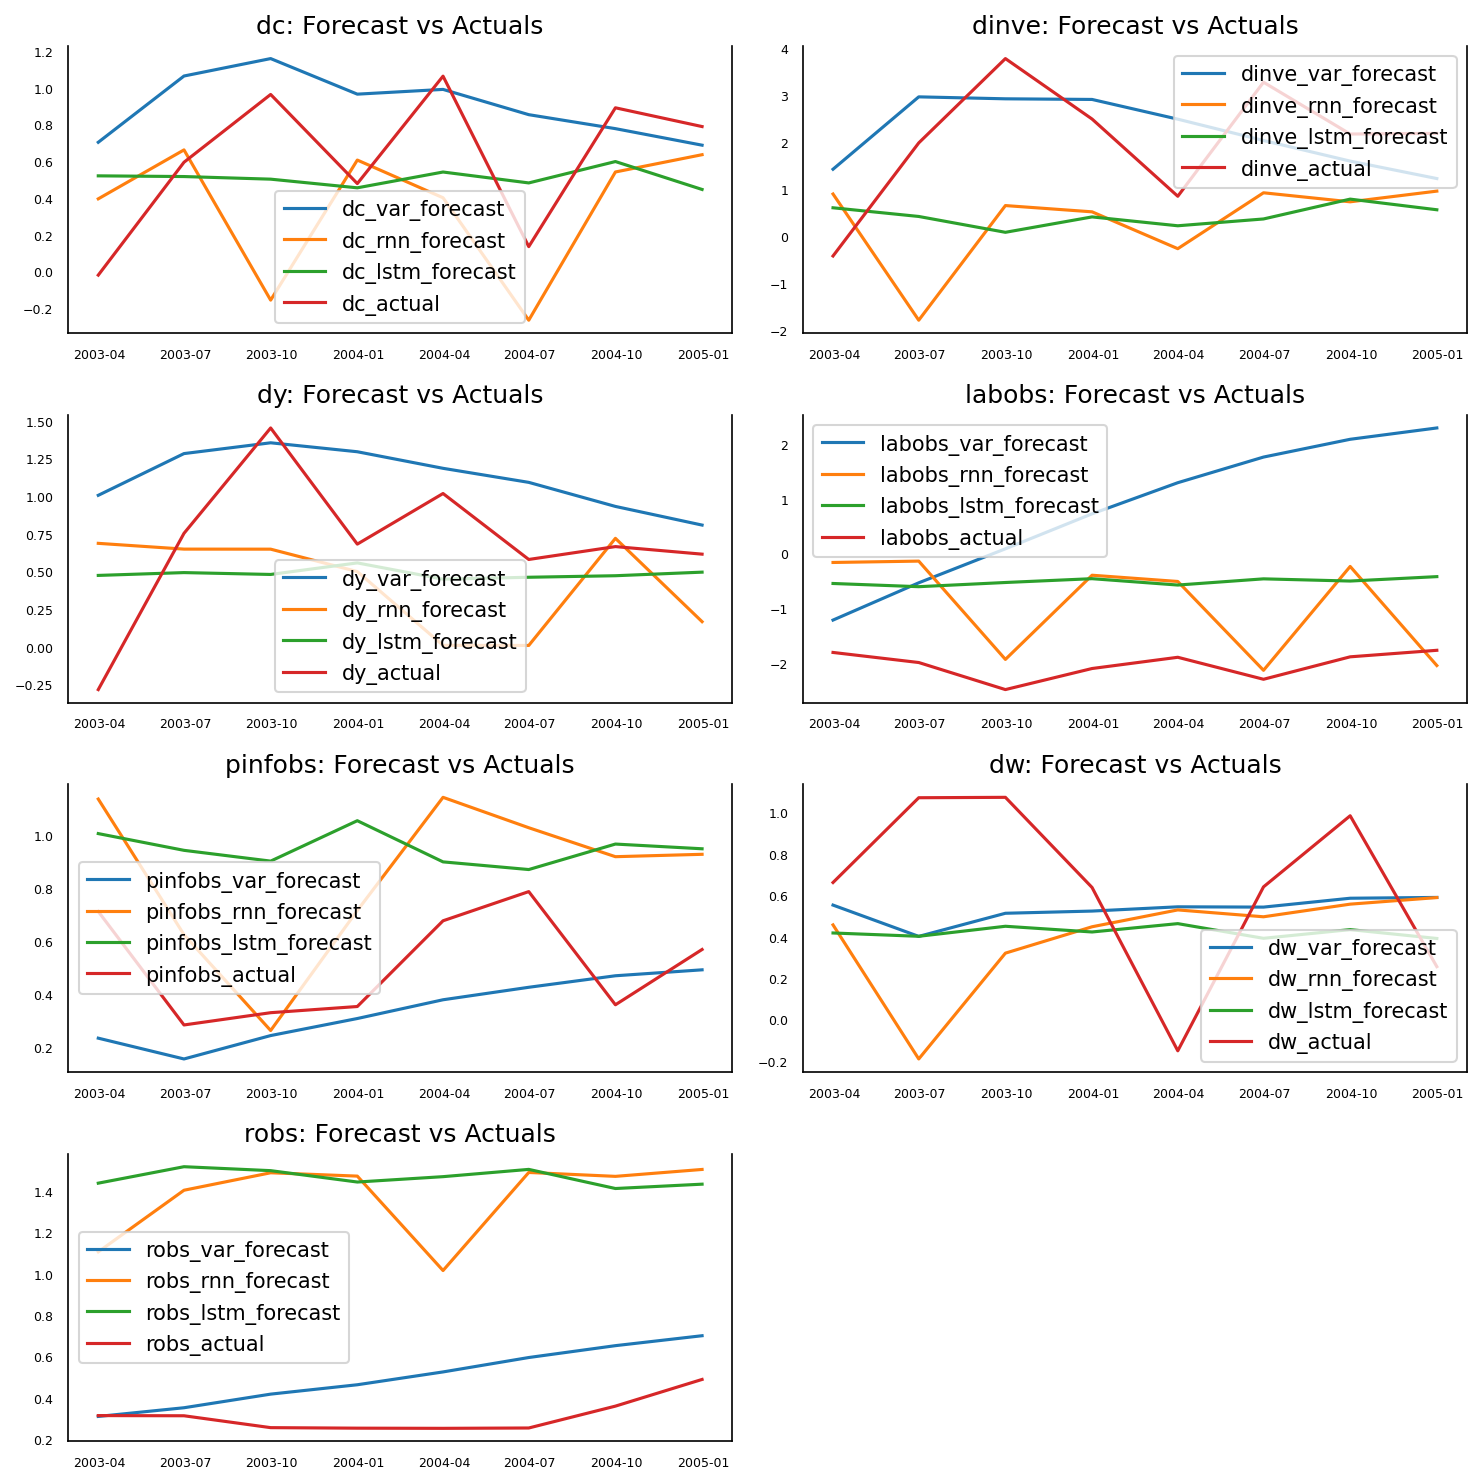

In [82]:
fig = plt.figure(dpi=150, figsize = (10, 10))
for i, col in enumerate(data.columns):
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(var_forecast[col+'_var_forecast'], label=col+'_var_forecast')
    ax.plot(rnn_forecast[col+'_rnn_forecast'], label=col+'_rnn_forecast')
    ax.plot(lstm_forecast[col+'_lstm_forecast'], label=col+'_lstm_forecast')
    ax.plot(test[col][-nobs:], label=col+'_actual')
    ax.set_title(col + ": Forecast vs Actuals")
    ax.legend(loc='best')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout();

As the figure shows, except for the forecast for labor, VAR follows the original data more closely as compared to NN. Between the NN models, RNN yields more volatile results than LSTM. 

## MSE for different periods

In [117]:
mse_var = pd.DataFrame((test[-nobs:].values - var_forecast.values)**2, columns = ['mse_'+col for col in var_forecast.columns], index=test[-nobs:].index).mean(axis=1)
mse_rnn = pd.DataFrame((test[-nobs:].values - rnn_forecast.values)**2, columns = ['mse_'+col for col in rnn_forecast.columns], index=test[-nobs:].index).mean(axis=1)
mse_lstm = pd.DataFrame((test[-nobs:].values - lstm_forecast.values)**2, columns = ['mse_'+col for col in lstm_forecast.columns], index=test[-nobs:].index).mean(axis=1)

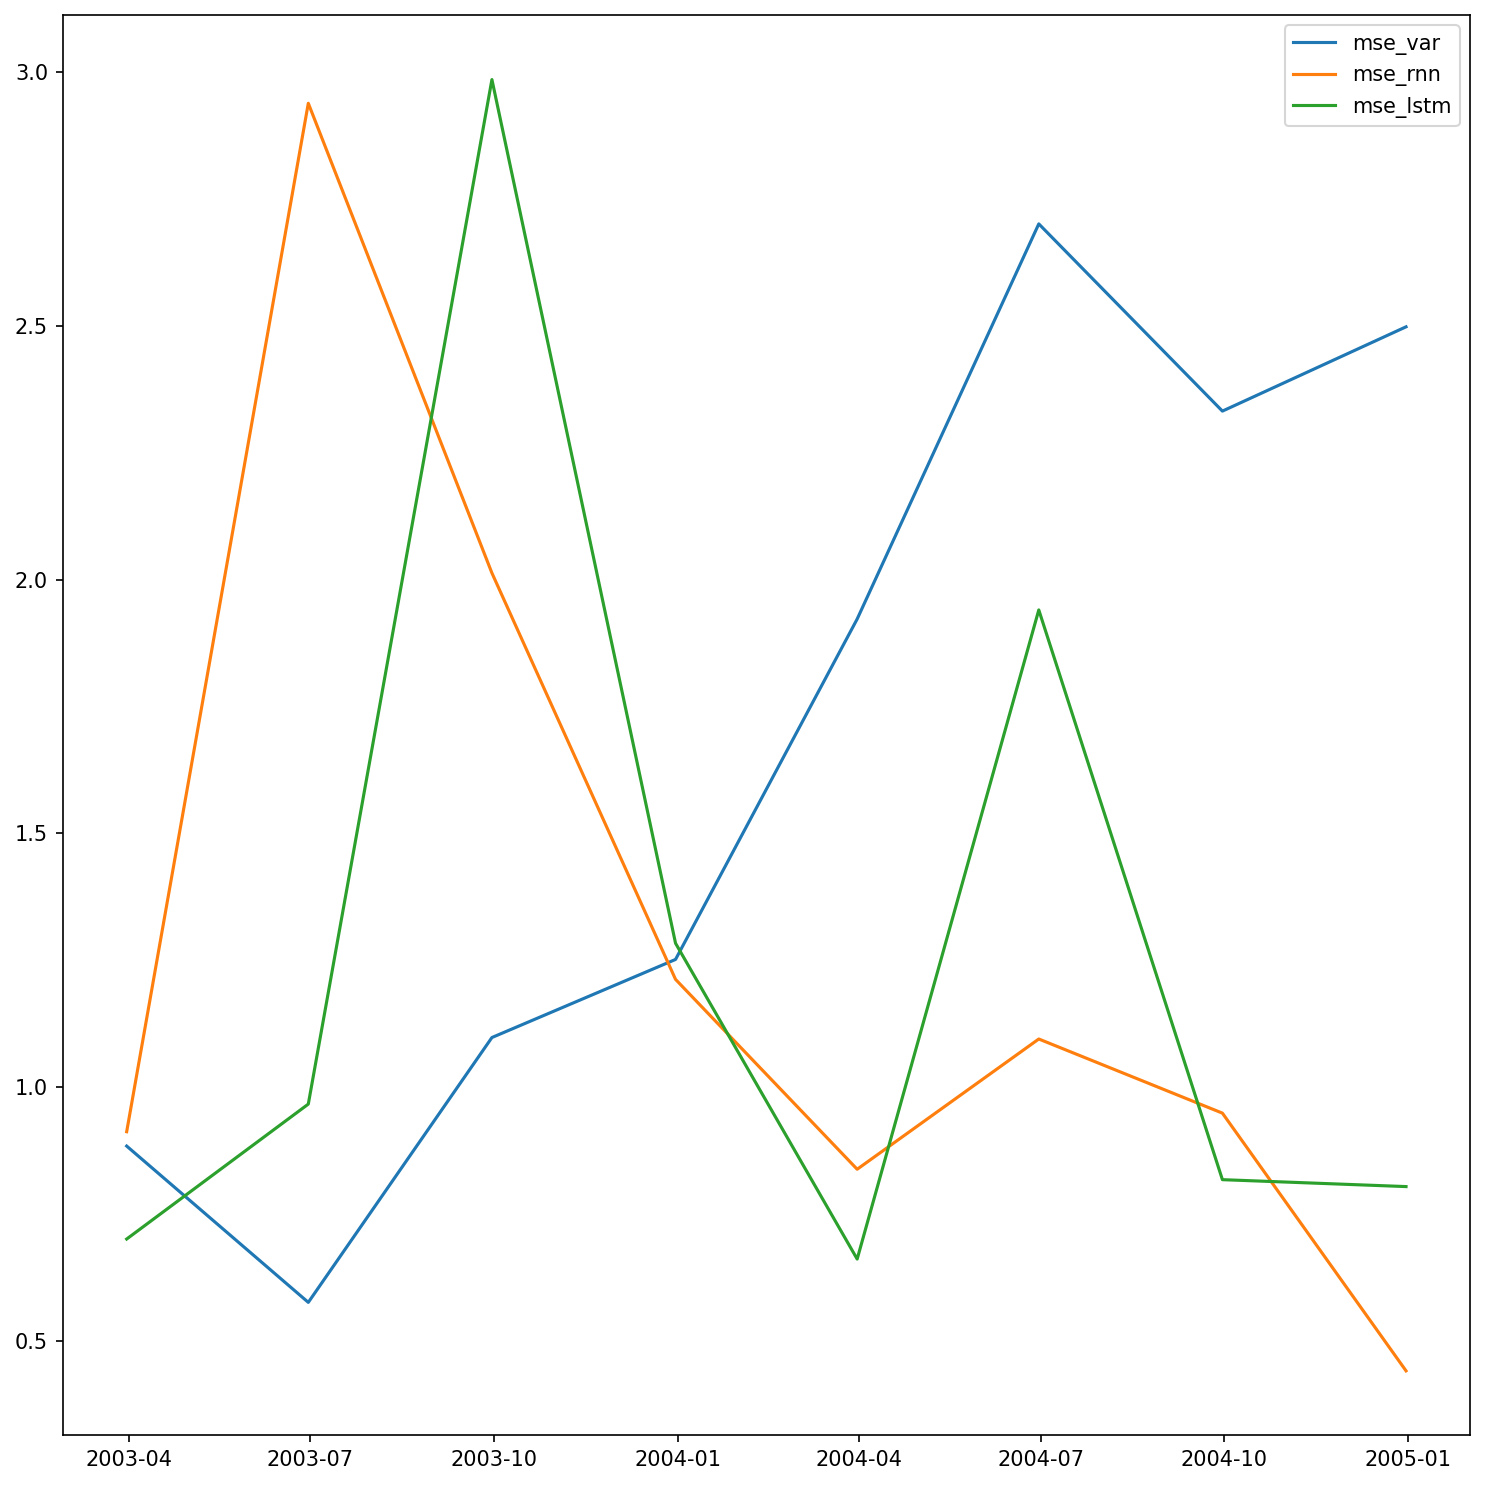

In [122]:
fig = plt.figure(dpi=150, figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(mse_var, label='mse_var')
ax.plot(mse_rnn, label='mse_rnn')
ax.plot(mse_lstm, label='mse_lstm')
ax.legend(loc='best')

plt.tight_layout()

The plot shows that although the VAR model makes better predictions than the NN models in the first 3 forecast periods, this advantage does not last beyond 4 periods. This result is in line with theory: Asymptotically, the VAR model produces errors that increase over the forecast horizon. The VAR model uses its own outputs as inputs in the next step, which can cause the errors to accumulate. Since our NN models yield sequences as outputs and use only the true inputs to predict all the future steps at once, it does not suffer from error accumulation. Therefore NN models perform better further into the future. And in general, LSTM outperforms RNN.

## Mean squared error for different features

| Variables | VAR | RNN | LSTM |
| --- | --- | --- | --- |
| dc | 0.1954 | 0.27400581 | 0.13838664 |
| dinve | 1.3465 | 5.00790936 | 4.36996046 |
| dy | 0.3412 | 0.39786991 | 0.24932159 |
| labobs | 9.4155 | 1.7453293 | 2.33646645 |
| pinfobs | 0.0615 | 0.14376815 | 0.23889902 |
| dw | 0.1942 | 0.37750757 | 0.21310338 |
| robs | 0.0492 | 1.1516426 | 1.34234679 |

We take the mean squared error over the 8 months as a performance measure. In absolute values, the prediction accuracy is good for none of the models. When it comes to comparison, except for labor, VAR has lower MSE's for almost every feature. The LSTM model also beats the RNN model in almost every feature. This shows that the memory mechanism does improve performance of neural network models, but it does not provide advantage over vector-autoregression models. Therefore the advantage of LSTM over RNN in analyzing this macroeconomic dataset might be that some unuseful information is filtered out in LSTM, but on average, the data long ago does not provide useful information for the present, which is why LSTM does not win over VAR.